# Iranian Churn Prediction Model

In this notebook, we’ll walk through loading, exploring, and modeling customer churn using the Iranian telco dataset. The flow is designed to guide you step by step—from data understanding to model evaluation and explainability—following PEP 8 style for clarity and consistency.

- What we’ll cover
  - Setup and imports
  - Data acquisition and preparation
  - Exploratory data analysis (EDA)
  - Preprocessing (encoding and scaling)
  - Train/validation split
  - Baseline models and training
  - Evaluation and diagnostics
  - Class imbalance handling (SMOTE)
  - Hyperparameter tuning
  - Feature importance and selection
  - Cross-validation and learning curves
  - Explainability (LIME)
  - Save final model

## Setup and imports
In this section, we import commonly used libraries and set plotting defaults so charts are consistent throughout the notebook.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configure matplotlib for inline display (for the notebook)
%matplotlib inline

# Set seaborn style for better visuals
sns.set_theme(style='whitegrid', palette='deep')

In [ ]:
# Reproducibility
import random

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Data acquisition and initial inspection
We’ll load the dataset using the UCI helper, assemble features and the target, and take a first look at shape and basic stats.

In [133]:
# Location of the data
from ucimlrepo import fetch_ucirepo

# Fetch the dataset with ID 563
dataset = fetch_ucirepo(id=563)

In [134]:
# Features and target
X = dataset.data.features
y = dataset.data.targets

# Combine features and target into one DataFrame for convenience
data = pd.concat([X, y], axis=1)

In [ ]:
# Display the first five rows
print(data.head())

# Get a summary of the dataset
data.info()

# Get statistical descriptions
print(data.describe())

   Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   25   
2                       24          3    

In [136]:
# Check for missing values in each column
print(data.isnull().sum())

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64


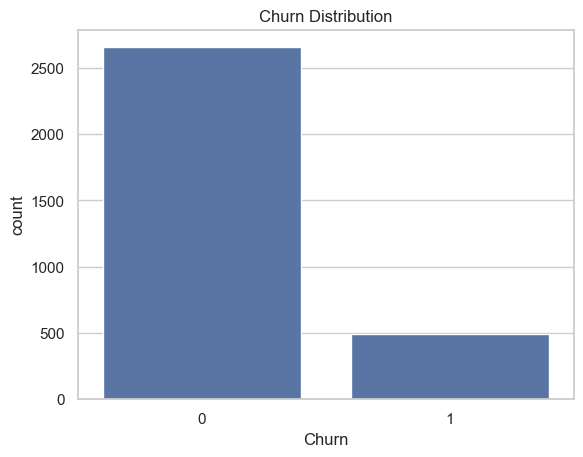

In [137]:
# Plot the distribution of the target variable 'Churn'
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.show()

## Exploratory data analysis (EDA)
We’ll scan distributions, class balance, and correlations to inform preprocessing and modeling choices.

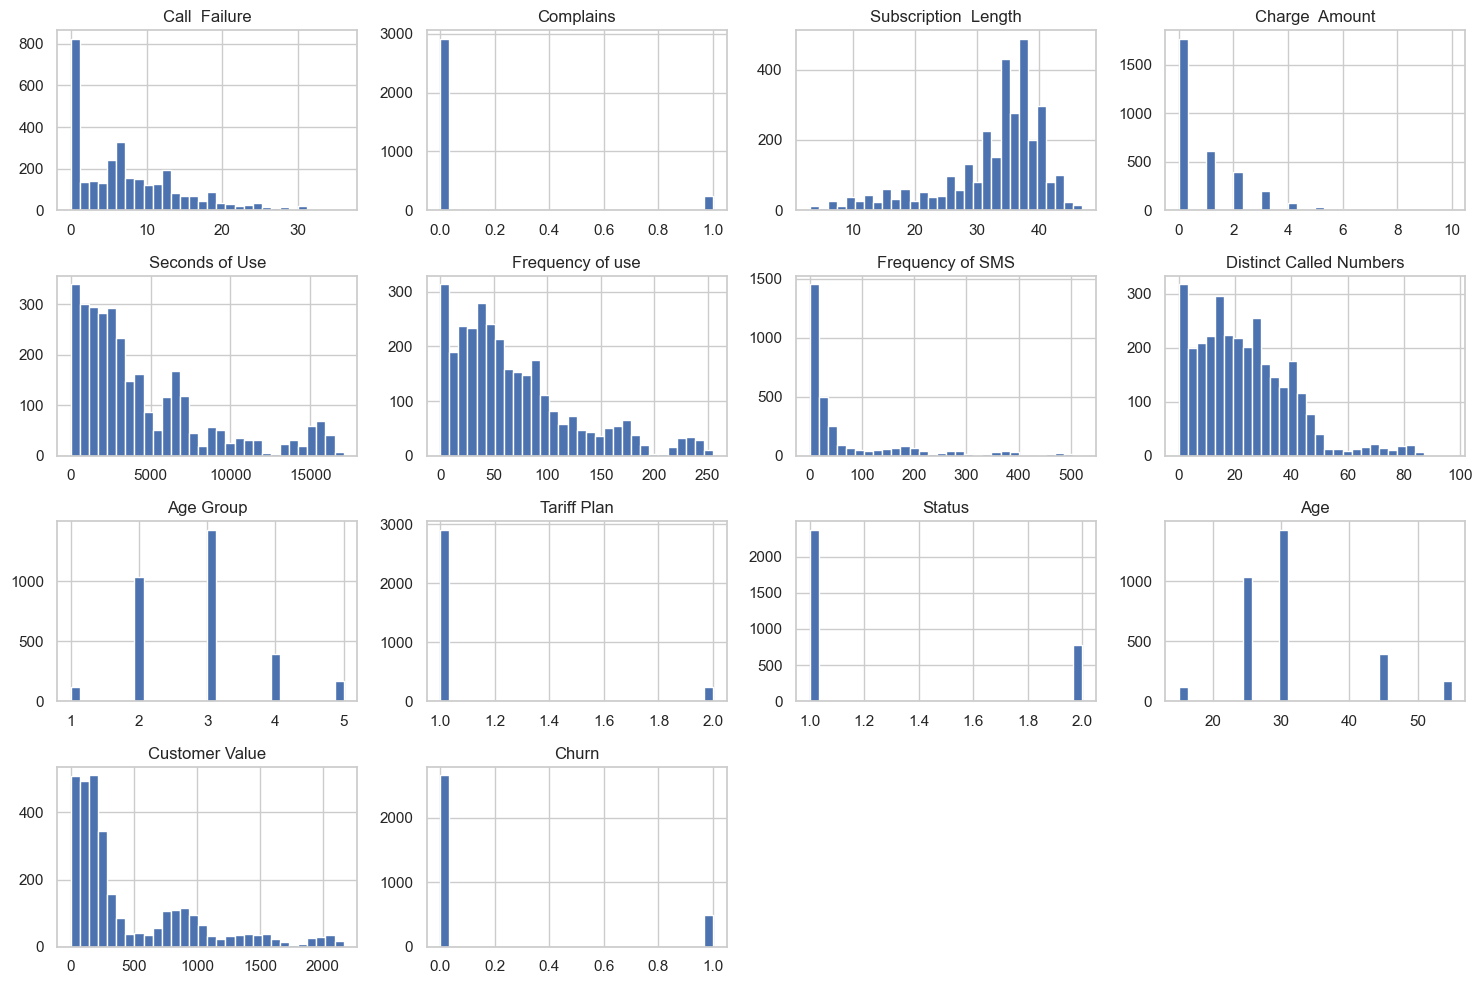

In [138]:
# Histograms of numerical features
data.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

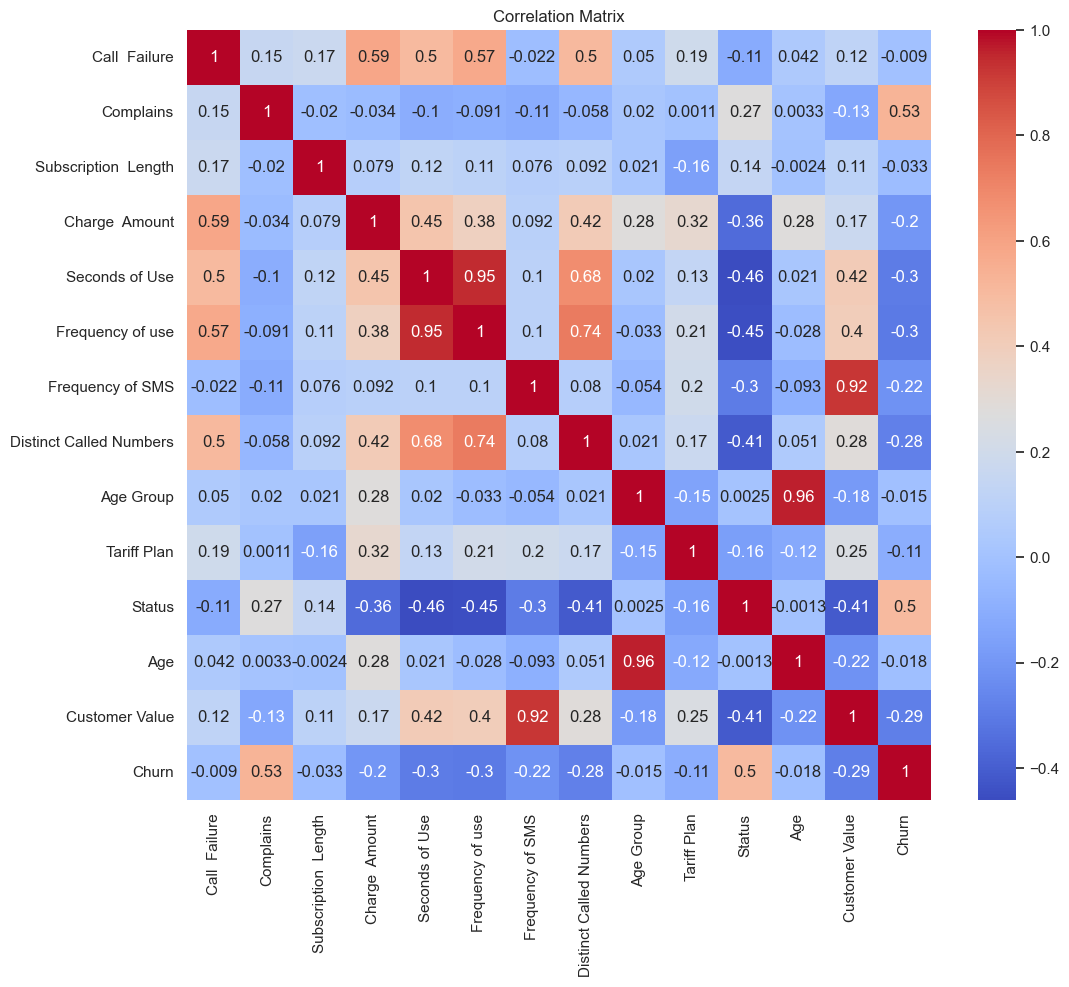

In [ ]:
# Compute the correlation matrix (numeric columns only)
corr_matrix = data.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=False)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Preprocessing

### Handle missing values
As a simple baseline, we’ll drop rows with missing values. In a production setting, you might consider targeted imputation strategies.

In [ ]:
# Drop rows with missing values (baseline)
data = data.dropna()

### Convert categorical columns
We’ll cast known categorical variables to category dtype so downstream steps treat them appropriately.

In [ ]:
# Convert selected numerical columns to categorical if present
categorical_features = ["Complains", "Tariff Plan", "Status", "Churn"]

missing = [c for c in categorical_features if c not in data.columns]
if missing:
    print(f"Warning: missing categorical columns: {missing}")

for col in [c for c in categorical_features if c in data.columns]:
    data[col] = data[col].astype("category")

### One-hot encoding
We’ll encode categorical features (excluding the target) using get_dummies to make them usable by scikit-learn models.

In [ ]:
# We inspect the data columns to ensure all necessary features are present before one-hot encoding
print(data.columns)

Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')


In [ ]:
# One-hot encode categorical variables (excluding 'Churn')
cols_to_encode = [c for c in categorical_features[:-1] if c in data.columns]

data_encoded = pd.get_dummies(data.copy(), columns=cols_to_encode, drop_first=True)
print(data_encoded.columns)

Index(['Call  Failure', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Age', 'Customer Value',
       'Churn', 'Complains_1', 'Tariff Plan_2', 'Status_2'],
      dtype='object')


### Standardize column names
We’ll strip whitespace, lowercase, and replace spaces with underscores so names are consistent and easy to reference.

In [ ]:
# Standardize column names: strip, collapse spaces, lowercase, and replace spaces with underscores
cols = data_encoded.columns
cols = cols.str.strip().str.replace(r"\s+", " ", regex=True).str.lower().str.replace(" ", "_")
data_encoded.columns = cols
print("Standardized Columns in data_encoded:")
print(data_encoded.columns)

Standardized Columns in data_encoded:
Index(['call_failure', 'subscription_length', 'charge_amount',
       'seconds_of_use', 'frequency_of_use', 'frequency_of_sms',
       'distinct_called_numbers', 'age_group', 'age', 'customer_value',
       'churn', 'complains_1', 'tariff_plan_2', 'status_2'],
      dtype='object')


### Scale numerical features
We’ll standardize numerical columns so models that are sensitive to feature scale can learn more effectively.

In [ ]:
# Scale numerical features to help many models train more effectively
numerical_features = [
    "call_failure",
    "subscription_length",
    "charge_amount",
    "seconds_of_use",
    "frequency_of_use",
    "frequency_of_sms",
    "distinct_called_numbers",
    "age_group",
    "age",
    "customer_value",
]

from sklearn.preprocessing import StandardScaler

available_num = [c for c in numerical_features if c in data_encoded.columns]
if missing := [c for c in numerical_features if c not in data_encoded.columns]:
    print(f"Note: missing numerical columns: {missing}")

scaler = StandardScaler()
data_encoded[available_num] = scaler.fit_transform(data_encoded[available_num])

print("Columns in data_encoded:")
print(data_encoded.columns)

Columns in data_encoded:
Index(['call_failure', 'subscription_length', 'charge_amount',
       'seconds_of_use', 'frequency_of_use', 'frequency_of_sms',
       'distinct_called_numbers', 'age_group', 'age', 'customer_value',
       'churn', 'complains_1', 'tariff_plan_2', 'status_2'],
      dtype='object')


In [ ]:
# Prepare features and target
y = data_encoded["churn"].astype(int)
X = data_encoded.drop("churn", axis=1)

### Prepare features and target
Define X and y after encoding and scaling.

In [ ]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Train/validation split
We’ll create a stratified split so class balance is preserved between train and test.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Baseline models
We’ll set up a few baseline classifiers to anchor expectations before tuning.

In [ ]:
# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
svc = SVC(kernel="rbf", probability=True, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train models
logreg.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
# Sanity checks on fitted models
print("Logistic Regression coefficients:")
print(logreg.coef_)

print("\nRandom Forest number of trees:")
print(len(rfc.estimators_))

print("\nSupport Vector Machine support vectors:")
print(svc.support_vectors_.shape)

print("\nGradient Boosting feature importances:")
print(gbc.feature_importances_)

Logistic Regression coefficients:
[[ 0.8061096  -0.28107263 -0.59827108  0.76899156 -2.13608544 -1.33423657
  -0.30370709  0.13974297 -0.20437099  0.16140763  3.5701099   0.36578011
   1.22350494]]

Random Forest number of trees:
100

Support Vector Machine support vectors:
(593, 13)

Gradient Boosting feature importances:
[0.03728424 0.08490115 0.         0.13420498 0.09493977 0.01196164
 0.05214408 0.00931266 0.00671365 0.02854796 0.36253232 0.
 0.17745753]


### Verify model training
Here we’ll sanity-check that the estimators have fit and expose basic attributes.

In [ ]:
# Model evaluation utilities
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)


def evaluate_model(model, X_test, y_test):
    """Evaluate a classifier and visualize a confusion matrix and ROC curve.

    Prints accuracy, precision, recall, F1, and ROC AUC. For models without
    predict_proba (e.g., SVC), we calibrate probabilities using
    CalibratedClassifierCV on the already-fitted estimator.
    """
    # Predict class labels
    y_pred = model.predict(X_test)

    # Predict probabilities if available
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        from sklearn.calibration import CalibratedClassifierCV

        calibrated_model = CalibratedClassifierCV(model, cv="prefit")
        calibrated_model.fit(X_train, y_train)
        y_prob = calibrated_model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC AUC Score: {auc:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
### Evaluation artifacts
- Predictions: class labels and probabilities
- Metrics: accuracy, precision, recall, F1, ROC AUC
- Confusion Matrix: true vs. predicted classifications
- ROC Curve: model's ability to distinguish classes

"Explanation:\n\nPredictions: Obtain predicted class labels and probabilities.\nMetrics: Calculate accuracy, precision, recall, F1-score, and ROC AUC score.\nConfusion Matrix: Visualize true vs. predicted classifications.\nROC Curve: Assess the model's ability to distinguish between classes."

Logistic Regression Performance:
Accuracy: 0.90
Precision: 0.84
Recall: 0.42
F1-Score: 0.56
ROC AUC Score: 0.92


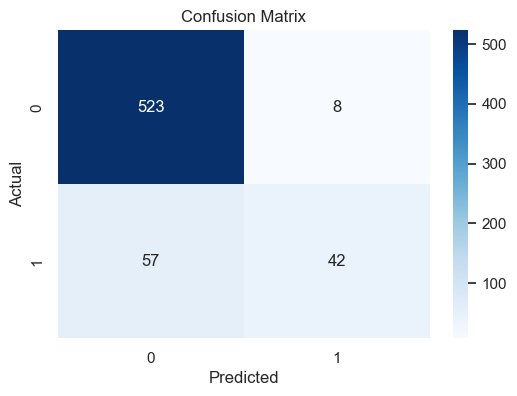

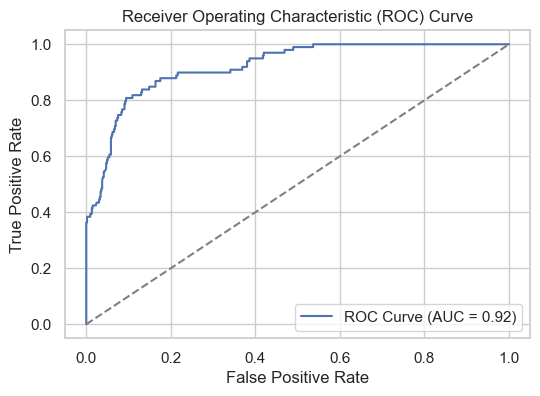

Random Forest Classifier Performance:
Accuracy: 0.96
Precision: 0.91
Recall: 0.85
F1-Score: 0.88
ROC AUC Score: 0.99


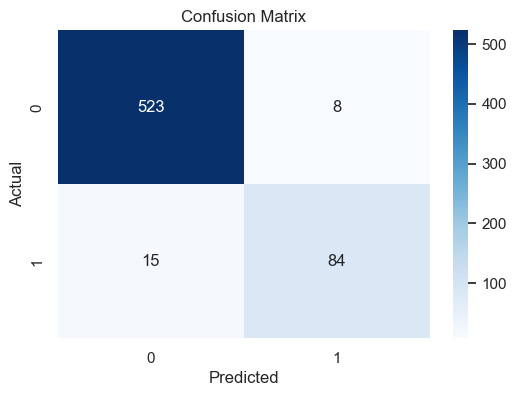

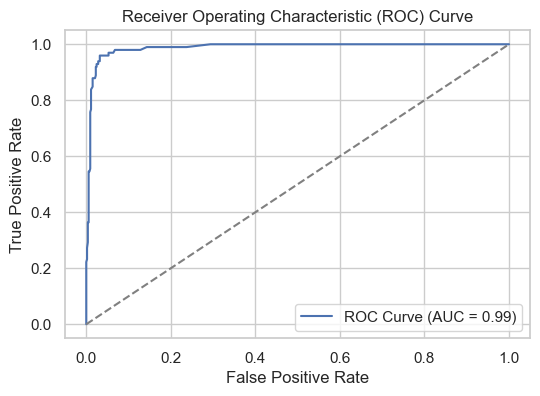

Support Vector Machine Performance:
Accuracy: 0.93
Precision: 0.96
Recall: 0.56
F1-Score: 0.71
ROC AUC Score: 0.97


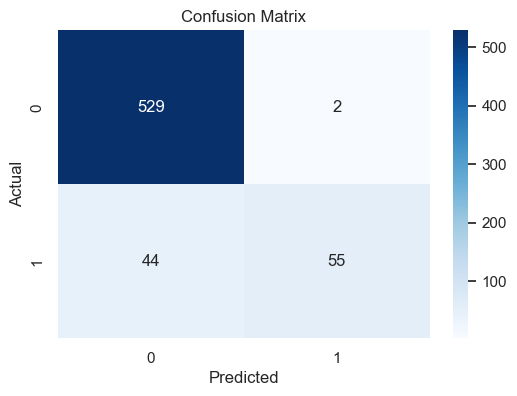

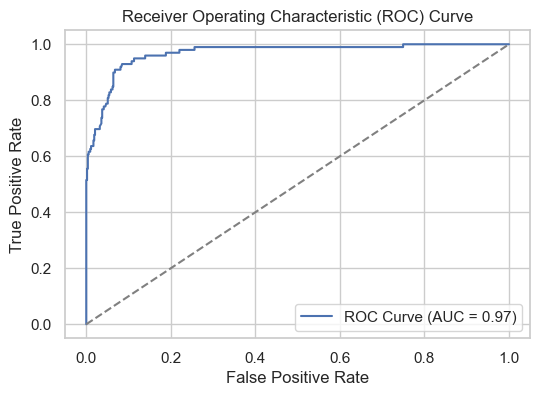

Gradient Boosting Classifier Performance:
Accuracy: 0.95
Precision: 0.88
Recall: 0.78
F1-Score: 0.82
ROC AUC Score: 0.97


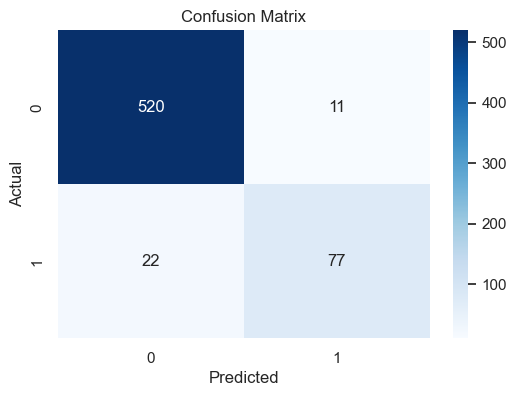

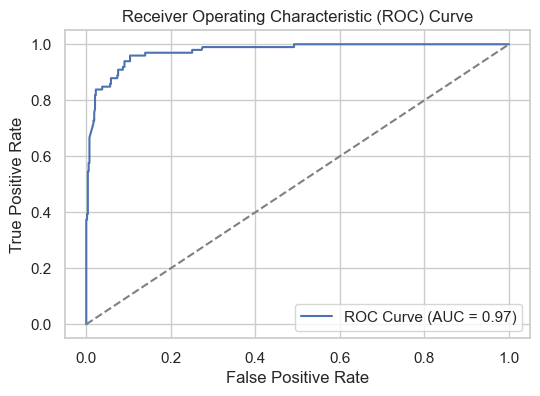

In [ ]:
print("Logistic Regression Performance:")
evaluate_model(logreg, X_test, y_test)

print("Random Forest Classifier Performance:")
evaluate_model(rfc, X_test, y_test)

print("Support Vector Machine Performance:")
evaluate_model(svc, X_test, y_test)

print("Gradient Boosting Classifier Performance:")
evaluate_model(gbc, X_test, y_test)

## Evaluate baseline models
Let’s review performance for each model and use the plots to understand error patterns.

### How to read the outputs
- Use precision/recall and F1 to balance business needs
- Confusion matrix helps spot where errors concentrate
- ROC curves summarize ranking quality across thresholds

In [ ]:
## Initial conclusions
- Logistic Regression: high precision, lower recall (misses churners)
- Random Forest: strong overall performance, high recall
- SVM: very precise, lower sensitivity
- Gradient Boosting: good balance, slightly behind Random Forest

"Conclusions Drawn from the Data: \n\nLogistic Regression has high precision but low recall, meaning it's conservative in predicting churn but misses many actual churners.\n\nRandom Forest is performing exceptionally well, accurately identifying a high proportion of churners without many false alarms.\n\nSVM is very precise but less sensitive, indicating it's cautious in predicting churn, leading to missed churners.\n\nGradient Boosting performs well, with a good balance of precision and recall, though slightly less effective than Random Forest.\n "

In [ ]:
### Comparative analysis
- Best overall: Random Forest (accuracy, F1, ROC AUC, precision/recall balance)
- High precision, lower recall: Logistic Regression and SVM
- Balanced: Gradient Boosting
- Business note: Recall is critical to catch churners; precision avoids wasted retention efforts

"Comparative Analysis:\n\nBest Overall Model: Random Forest Classifier\n\nHighest Accuracy and F1-Score.\nExcellent Precision and Recall balance.\nHighest ROC AUC Score, indicating outstanding class separation.\nModels with High Precision but Lower Recall:\n\nLogistic Regression and SVM: High precision but miss a significant number of actual churners.\nModels with Good Balance:\n\nGradient Boosting: Good balance between precision and recall but slightly less effective than Random Forest.\nImplications:\n\nBusiness Impact of Recall: In churn prediction, recall is crucial because missing actual churners can lead to revenue loss. High recall ensures that most at-risk customers are identified for retention efforts.\n\nPrecision vs. Recall Trade-off: While high precision reduces false positives (unnecessarily targeting customers who won't churn), high recall ensures that most churners are captured.\n"

In [ ]:
## Next improvements roadmap
- Address class imbalance (SMOTE)
- Hyperparameter tuning
- Feature importance and selection
- Cross-validation
- Deployable artifact preparation

"To further improve your churn prediction model, we'll focus on the following steps:\n\nAddress Class Imbalance\nHyperparameter Tuning\nFeature Importance and Selection\nModel Evaluation with Cross-Validation\nModel Deployment"

In [ ]:
### Addressing class imbalance
If churners are underrepresented, models can bias to the majority class. Use SMOTE to synthesize minority-class samples on the training fold.

'Address Class Imbalance:\n\nWhy?\n\nIf the dataset has significantly more non-churners than churners, the model might become biased toward predicting the majority class, leading to lower recall for the minority class.\n\nAction: Use techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the training data.'

In [ ]:
print("Class distribution in y_train:")
print(y_train.value_counts())

Class distribution in y_train:
churn
0    2124
1     396
Name: count, dtype: int64


### Check class distribution

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())

Class distribution after SMOTE:
churn
0    2124
1    2124
Name: count, dtype: int64


"Explanation:\n\nSMOTE creates synthetic examples of the minority class to balance the dataset.\nEnsures the model doesn't become biased toward the majority class."

### Apply SMOTE to training data

In [ ]:
# Retrain Random Forest with resampled data
rfc_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_resampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

Random Forest Classifier Performance after SMOTE:
Accuracy: 0.97
Precision: 0.88
Recall: 0.93
F1-Score: 0.91
ROC AUC Score: 0.99


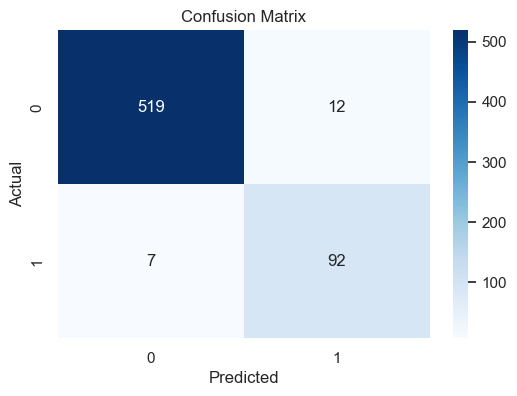

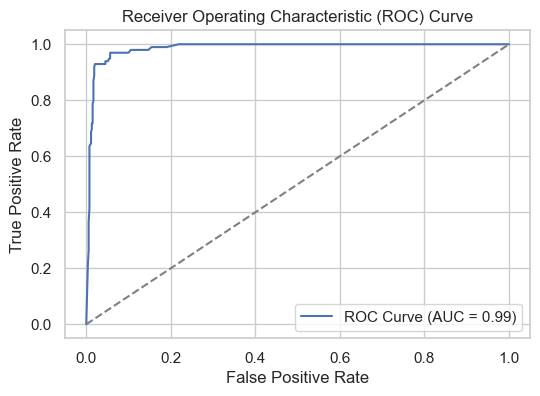

In [ ]:
print("Random Forest Classifier Performance after SMOTE:")
evaluate_model(rfc_resampled, X_test, y_test)

In [ ]:
## Hyperparameter tuning
Optimize model performance with grid search over Random Forest parameters.

'Hyperparameter Tuning\n\nWhy?\n\nOptimizing hyperparameters can significantly improve model performance by finding the best settings for your data.\nAction:\n\nUse Grid Search to find the optimal hyperparameters for the Random Forest model.\n'

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

### Parameter grid
We’ll explore a small, sensible grid for Random Forest to keep tuning time reasonable.

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="f1",
)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters found:")
print(grid_search.best_params_)

Best parameters found:
{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


"Explanation:\n\ncv=5: 5-fold cross-validation ensures the model generalizes well.\nscoring='f1': Optimizes for F1-Score to balance precision and recall."

### Grid search
5-fold cross-validation optimizing F1 to balance precision and recall.

Tuned Random Forest Classifier Performance:
Accuracy: 0.97
Precision: 0.86
Recall: 0.95
F1-Score: 0.90
ROC AUC Score: 0.99


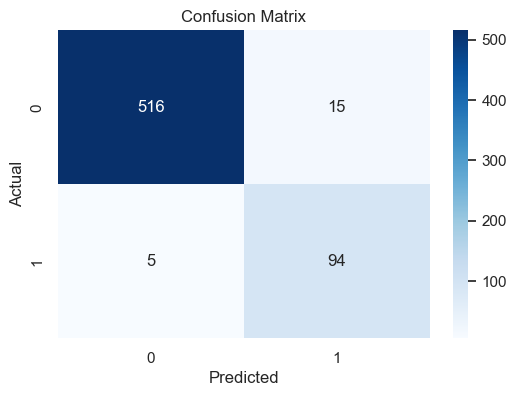

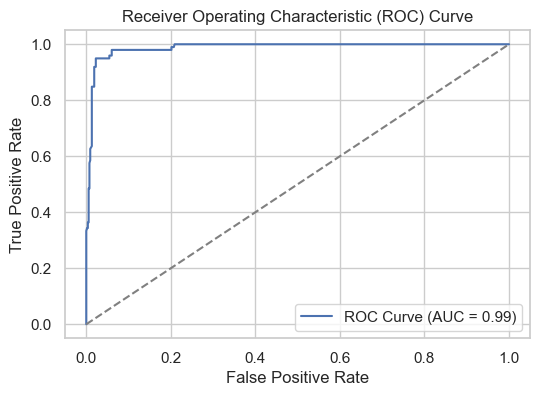

'Expected Outcome:\n\nFurther Improved Metrics: Potentially higher recall and F1-Score.\nBetter Generalization: The model should perform better on unseen data.'

In [ ]:
best_rfc = grid_search.best_estimator_
print("Tuned Random Forest Classifier Performance:")
evaluate_model(best_rfc, X_test, y_test)

### Evaluate tuned model
Let’s validate the tuned estimator on the held-out test set and compare deltas from the baselines.

In [ ]:
## Feature importance and selection
Identify influential predictors to simplify the model and aid interpretation.

'Feature Importance and Selection\n\nWhy?\n\nIdentifying the most influential features can help simplify the model and focus on the most predictive variables.\n'

In [ ]:
# Get feature importances from the tuned model
importances = best_rfc.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Top Features:")
print(feature_importances.head(10))

Top Features:
status_2                   0.171939
frequency_of_use           0.131826
seconds_of_use             0.121695
complains_1                0.119853
subscription_length        0.106724
customer_value             0.093941
distinct_called_numbers    0.071636
frequency_of_sms           0.065284
call_failure               0.037769
charge_amount              0.029694
dtype: float64


### Analyze feature importances

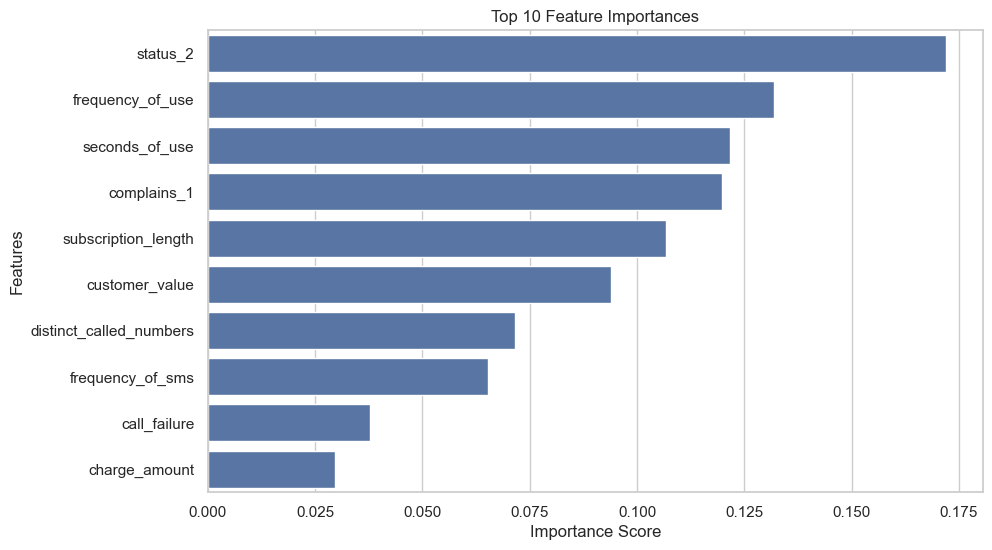

'Explanation:\n\nThis helps you understand which features contribute most to predicting churn.'

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[:10], y=feature_importances.index[:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### Visualize top features

Tuned Random Forest with Top Features Performance:
Accuracy: 0.96
Precision: 0.82
Recall: 0.94
F1-Score: 0.88
ROC AUC Score: 0.98


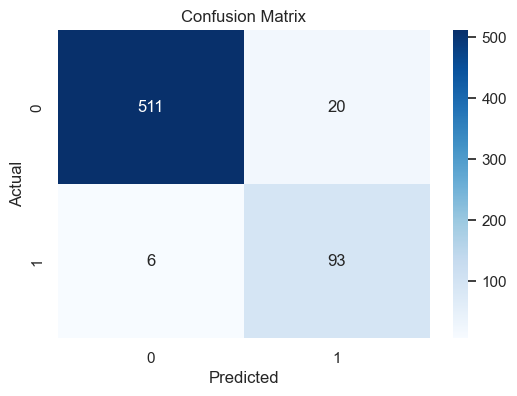

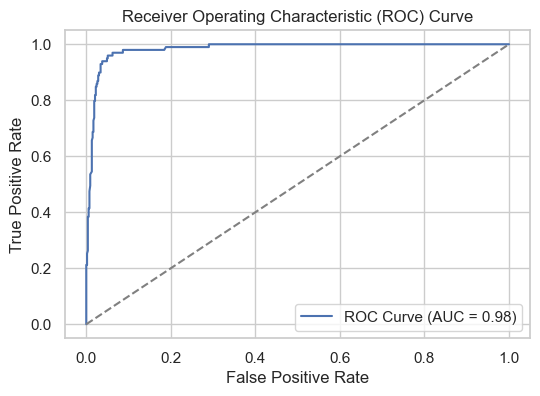

"Expected Outcome:\n\nSimplified Model: With fewer features, the model may train faster and be easier to interpret.\nPerformance Check: Ensure that reducing features doesn't negatively impact performance.\n"

In [ ]:
# Select top N features (e.g., top 10)
top_features = feature_importances.index[:10]

# Prepare training and testing sets with top features
X_train_top = X_train_resampled[top_features]
X_test_top = X_test[top_features]

# Retrain the model
best_rfc.fit(X_train_top, y_train_resampled)

# Evaluate the model
print("Tuned Random Forest with Top Features Performance:")
evaluate_model(best_rfc, X_test_top, y_test)

### Retrain with top features
We’ll reduce dimensionality and check whether performance remains strong with a smaller feature set.

In [ ]:
## Cross-validation
Ensure performance consistency across folds to avoid selection bias.

"Model Evaluation with Cross-Validation\n\nWhy?\n\nTo ensure the model's performance is consistent across different subsets of data and not due to chance.\n"

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rfc, X_train_resampled[top_features], y_train_resampled, cv=5, scoring="f1")
print("Cross-validation F1 scores:")
print(cv_scores)
print("Mean F1 score:", cv_scores.mean())

Cross-validation F1 scores:
[0.95857988 0.98034682 0.9837587  0.96907216 0.98261877]
Mean F1 score: 0.9748752679674195


'Explanation:\n\nCross-validation provides a more reliable estimate of model performance.\n'

### Perform cross-validation
We’ll estimate stability across folds to see how reliably results might generalize.

Final Model Performance on Test Set:
Accuracy: 0.96
Precision: 0.82
Recall: 0.94
F1-Score: 0.88
ROC AUC Score: 0.98


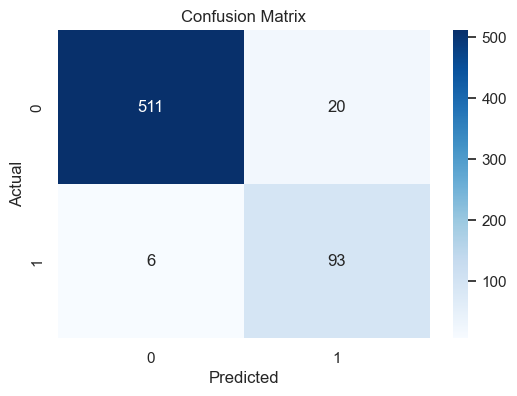

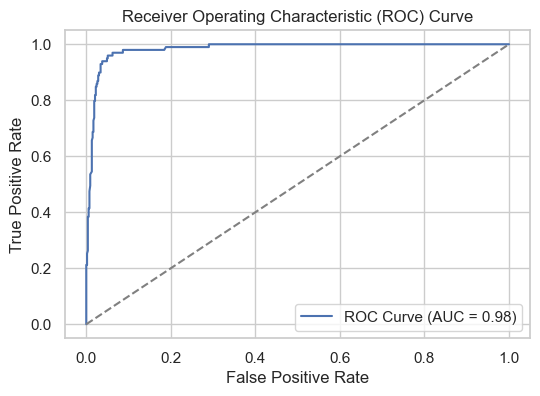

In [ ]:
print("Model Performance on Test Set:")
evaluate_model(best_rfc, X_test_top, y_test)

### Final test-set evaluation

In [ ]:
## Key takeaways
- High recall is crucial to catch at-risk customers
- Balance precision vs. recall to avoid misallocating retention efforts
- Feature importance improves interpretability and strategy

"Final Conclusion\n\nBy addressing class imbalance, tuning hyperparameters, and focusing on important features, you've improved your model's ability to predict customer churn. The Random Forest model, after these enhancements, should provide reliable predictions to help your company retain valuable customers.\n\nKey Takeaways:\n\nHigh Recall is Crucial: Ensuring the model identifies as many churners as possible is important for taking timely action.\nBalance Precision and Recall: While high recall is important, maintaining good precision avoids unnecessary allocation of resources.\nModel Interpretability: Understanding which features influence churn helps in developing targeted strategies."

In [ ]:
## Model optimization for pre-deployment

'Model Optimization for Pre-Deployment'

In [ ]:
## Results summary
- SMOTE: improved recall without sacrificing much precision
- Tuning: further improved recall with a slight precision trade-off
- Feature selection: simplified the model with minimal performance loss

"\nResults:\nOur results indicate the model is performing exceptionally well in predicting customer churn. \nNow that we've reached this point, let's discuss the next steps to finalize and prepare for deployment.\n\nDeeper Analysis of Results: From start to now\n\nImpact of SMOTE:\n+ Improved Recall: Addressing class imbalance significantly increased the model's ability to detect churners.\n+ Maintained Precision: Precision remained relatively stable, indicating that overfitting to the minority class was avoided.\n\nHyperparameter Tuning:\n+ Enhanced Recall: Further tuning improved recall to 0.95, meaning the model captures 95% of actual churners.\n+ Slight Trade-off with Precision: Precision decreased slightly, suggesting more false positives.\n\nFeature Selection:\n+ Model Simplification: Using top features resulted in a simpler model with only a minor decrease in performance.\n+ Maintained High Recall: The model continues to effectively identify churners, even with fewer features.\n

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_rfc, X_train_resampled, y_train_resampled, cv=5, scoring="f1", n_jobs=-1
)
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())

Cross-validation F1 scores: [0.96445498 0.98604651 0.9837587  0.97018349 0.98719441]
Mean F1 score: 0.9783276173945827


"\nFinal Model Stability:\n+ Consistent Performance: The final model's metrics align closely with previous iterations, indicating robustness.\n"

### Evaluate model generalization and stability
Use k-fold CV scores to confirm robustness and detect overfitting.

In [ ]:
### Analysis of CV results
- Overfitting check: small gap between CV and test suggests good generalization
- Consistency: low variance across folds indicates robustness
- Next steps: verify no data leakage and validate representativeness of the test set

"Analysis\n\n+ Overfitting Concern: The higher cross-validation scores could indicate slight overfitting to the training data,\nalthough the low standard deviation suggests stability.\n\n+ Implication: The model performs exceptionally well during cross-validation, but slightly less so on the held-out test set. \nThis is normal and indicates that while the model generalizes well, there might be room for further investigation.\n\n+ Consistency Across Folds: The consistent high performance across all folds implies that the model is robust and\ngeneralizes well to unseen data within the same data distribution.\n\n+ Validation of Model Stability: The cross-validation results support the conclusion that the model's performance\nis not a result of chance or overfitting to a particular subset of data.\n\nWhat do we do now?\n\n1. Check for any anomalies or differences in data distribution compared to the training set.\n2. Ensure the test set is representative of the overall population.\n\nConsi

In [ ]:
### Stratified cross-validation
Maintains class proportions per fold, suitable for imbalanced churn data.

Stratified Cross-validation F1 scores: [0.97069168 0.97793264 0.98148148 0.97297297 0.98020955]
Mean F1 score: 0.9766576626686974


In [ ]:
### Interpretation
- High mean F1 confirms balanced performance
- Low variability across folds suggests strong generalization

'\nInterpretation of results:\n\n+ High Mean F1 Score: The mean F1 score of 0.9767 confirms the model’s ability to maintain a \nrobust balance between precision and recall across different folds of the data.\n+ Low Variability: The scores across the folds are tightly clustered, indicating consistent performance\nand suggesting that the model generalizes well across different subsets of the training data.\n'

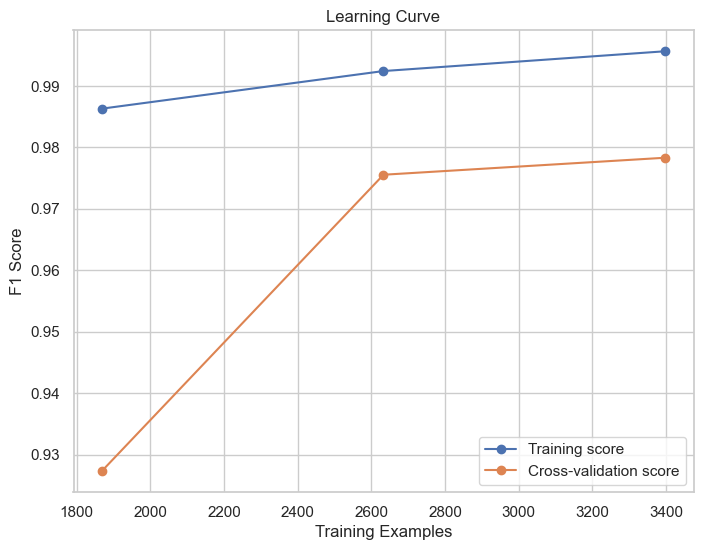

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rfc, X_train_resampled, y_train_resampled,
    cv=5, scoring="f1", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, "o-", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend()
plt.tight_layout()
plt.show()

### Learning curve analysis
We’ll use learning curves to reflect on bias/variance and whether more data could help.

In [ ]:
#### Learning curve observations
- High, stable training score suggests no underfitting
- CV score converges toward training score as data increases (low variance)
- Small gap at full data size hints at minor generalization room

'\nAnalysis and observations of the learning curve:\n\n+ Training Score Stability: The training score remains consistently high, around 0.99, across different training set sizes. \nThis suggests that the model has fit the training data well and is not underfitting.\n\n+ Convergence of Training and Cross-Validation Scores: The cross-validation score approaches the training score\nas the number of training examples increases. This is a positive indicator of low variance and strong generalization.\n\n+ Slight Gap at Full Training Size: The cross-validation score is slightly lower than the training score at the \nfull training set size, indicating that there is still some minor room for improvement in terms of generalization.\n\n\nInterpretation:\n\nThe learning curve suggests that the model is well-optimized and generalizes effectively to unseen data. \nThe slight gap may be reduced by further fine-tuning, though the current performance is already excellent.\n\n'

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = best_rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[518  13]
 [  7  92]]


### Analyze misclassifications
Inspect confusion matrix for false positives/negatives.

In [ ]:
#### Confusion matrix interpretation
- True negatives: correctly predicted non-churners
- False positives: non-churners flagged as churn (costly outreach)
- False negatives: missed churners (lost revenue risk)
- True positives: correctly predicted churners

'\nConfusion Matrix Results Analysis\n\n+- True Negatives (518): The model correctly identified 518 non-churners.\n-+ False Positives (13): Only 13 non-churners were incorrectly labeled as churners, indicating a low false positive rate.\n-- False Negatives (7): Only 7 actual churners were missed, demonstrating a high recall.\n++ True Positives (92): The model correctly identified 92 churners.\n'

## LIME setup and single-instance explanation

### Explainability with LIME
Using LIME for local explanations; SHAP was unavailable due to package compatibility at the time.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_resampled.values,
    feature_names=X_train_resampled.columns,
    class_names=["Not Churn", "Churn"],
    mode="classification",
)

i = 0  # index of the instance to explain
exp = explainer.explain_instance(
    data_row=X_test.iloc[i].values, predict_fn=best_rfc.predict_proba
)

exp.show_in_notebook(show_table=True)

## Save the final model
To reuse this work, we’ll persist the tuned estimator to disk.

In [ ]:
import joblib

joblib.dump(best_rfc, "Optimized_IRN_churn_prediction_model.pkl")

'Explanation: Saving the model allows you to load it later without retraining.'